Augment the literature data

In [74]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, dw_gen, perform_eval
from modelval.ArbDataGen import arb_w_gen

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [76]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]
data1_gen, targets1 = dw_gen.STDP_dw_gen(n_neighbors=3)

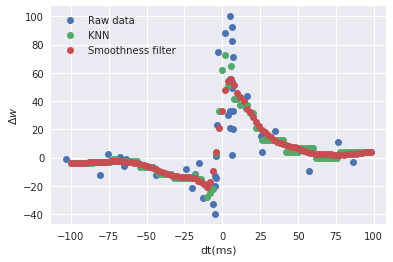

In [77]:
plt.plot(data1['dt1'], data1['dw_mean'],'o', label='Raw data')
width_list = np.concatenate([np.linspace(10,3,50), np.linspace(3,10,50)])
plt.plot(data1_gen['dt1'], targets1,'o', label='KNN')
targets1_sm = dw_gen.smooth(targets1,width_list = width_list)
plt.plot(data1_gen['dt1'],targets1_sm,'o', label='Smoothness filter')
plt.xlabel('dt(ms)')
plt.ylabel('$\Delta w$')
plt.legend(loc='upper left')

In [92]:
# Generate data for Triplet
dt = np.array([-10, -5, 0, 5, 10]).reshape(-1,1)
data2_gen, targets2 = dw_gen.triplet_dw_gen(dt)

In [96]:
data2 = data[data['ptl_idx']==2]
data2[data2['dt1']==dt[3][0]].iloc[0]

ptl_idx           2.000000
pre_spk_num       2.000000
pre_spk_freq      0.000000
post_spk_num      1.000000
post_spk_freq     0.000000
ptl_occ          60.000000
ptl_freq          1.000000
dt1               5.000000
dt2              -5.000000
dt3               0.000000
dw_mean          38.010645
dw_ste            0.000000
train_len        60.000000
Name: 63, dtype: float64

In [93]:
# Visualize the triplet data
data2_gen

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,2.0,2.0,0.0,1.0,0.0,60.0,1.0,-10.0,10.0,0.0,2.634968,0.0,60.0
1,2.0,2.0,0.0,1.0,0.0,60.0,1.0,-5.0,5.0,0.0,-0.162906,0.0,60.0
2,2.0,2.0,0.0,1.0,0.0,60.0,1.0,0.0,0.0,0.0,50.000000,0.0,60.0
3,2.0,2.0,0.0,1.0,0.0,60.0,1.0,5.0,-5.0,0.0,27.321098,0.0,60.0
4,2.0,1.0,0.0,2.0,0.0,60.0,1.0,10.0,-10.0,0.0,25.392321,0.0,60.0


[-110, 100, -30, 60]

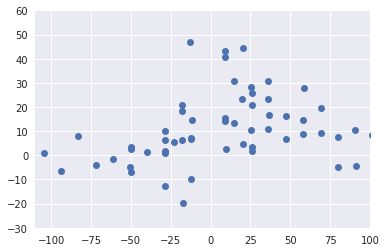

In [71]:
data3 = data[data['ptl_idx']==3]
X = np.array(data3['dt2']).reshape(-1,1)
y = np.array(data3['dw_mean']).reshape(-1,1)
plt.plot(data3['dt2'], data3['dw_mean'], 'o')
plt.axis([-110, 100, -30, 60])

In [8]:
# Generate dt1
# Insert values for Quadruplet
dt = np.concatenate([np.arange(-100,-10,2).reshape(-1,1), np.arange(10,100,2).reshape(-1,1)])
data3_gen = pd.DataFrame(data=None, columns=list(data.columns))
for i in range(len(dt)):
    new_try3 = data3.iloc[0]
    new_try3['dt2'] = dt[i]
    data3_gen = data3_gen.append(new_try3, ignore_index=True)

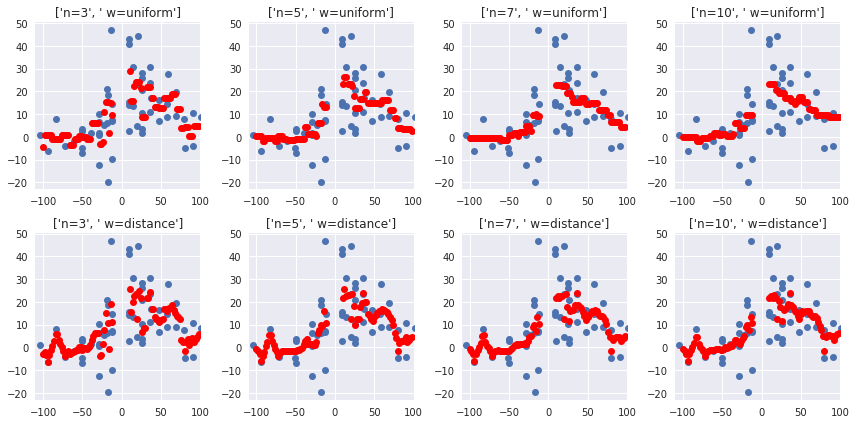

In [9]:
# Use K nearest neigbors to estimate the mean value of a given dt1
from sklearn.neighbors import KNeighborsRegressor

# Search through the parameter for the one gives the minimum reconstruction error
n_neighbors = [3,5,7,10]
weights = ['uniform', 'distance']

figure, ax = plt.subplots(2,4)
figure.set_figheight(6)
figure.set_figwidth(12)

for j in range(len(weights)):
    for i in range(len(n_neighbors)):
        
        Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors[i], weights=weights[j])
        Kn_reg.fit(X,y)
        y_pred = Kn_reg.predict(np.array(data3_gen['dt2']).reshape(-1,1))
        
        # Calculate mean squared error
        
        ax[j,i].plot(data3['dt2'], data3['dw_mean'], 'o')
        ax[j,i].plot(data3_gen['dt2'], y_pred, 'ro')
        ax[j,i].set_xlim([-110,100])
        ax[j,i].set_title(['n=%d'%(n_neighbors[i]), ' w=%s'%(weights[j])])
plt.tight_layout()

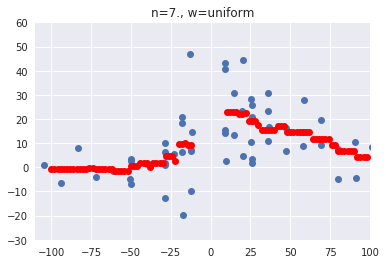

In [10]:
# Choose one parameter and generate the prediction
n_neighbors = 7
weights = 'uniform'

Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
Kn_reg.fit(X,y)
y_pred = Kn_reg.predict(np.array(data3_gen['dt2']).reshape(-1,1))
targets3=y_pred
plt.plot(data3['dt2'], data3['dw_mean'], 'o')
plt.plot(data3_gen['dt2'], y_pred, 'ro')
plt.axis([-110,100,-30,60])
plt.title('.'.join(('n=%d'%(n_neighbors), ', w=%s'%(weights))))

In [11]:
targets3.shape

(90, 1)

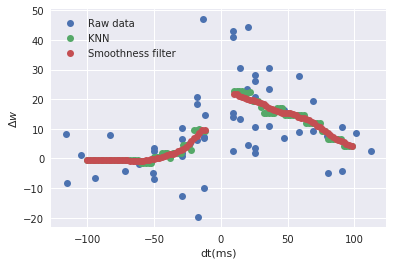

In [12]:
width_list = np.concatenate([np.linspace(10,3,45), np.linspace(3,10,45)])
targets3_sm = np.concatenate([dw_gen.smooth(targets3[:45],width_list = width_list), dw_gen.smooth(targets3[45:],width_list = width_list)])
plt.plot(data3['dt2'], data3['dw_mean'], 'o', label='Raw data')
plt.plot(data3_gen['dt2'], targets3,'o', label='KNN')
plt.plot(data3_gen['dt2'], targets3_sm,'o', label='Smoothness filter')
plt.xlabel('dt(ms)')
plt.ylabel('$\Delta w$')
plt.legend()

In [13]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

1.0 1.0


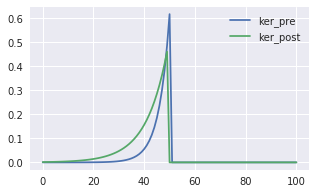

In [14]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

ker_test = KernelGen(len_kernel=101)
ker_test.trip_model_ker(para, data_name='Hippocampus')
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2))

In [15]:
data_gen = pd.concat([data1_gen, data2_gen, data3_gen])
targets = np.concatenate([targets1_sm, targets2, targets3_sm])

In [16]:
data_gen['ptl_idx'].value_counts()

1.0    100
3.0     90
2.0      5
Name: ptl_idx, dtype: int64

([<matplotlib.lines.Line2D at 0x7f6651f88400>],)

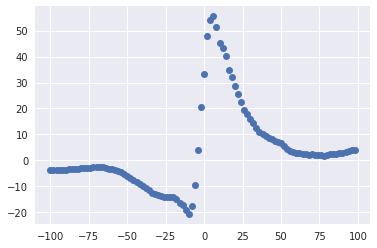

In [17]:
plt.plot(data_gen.iloc[:len(data1_gen)]['dt1'],targets[:targets1.shape[0]],'o'), 

([<matplotlib.lines.Line2D at 0x7f6651adc2b0>],)

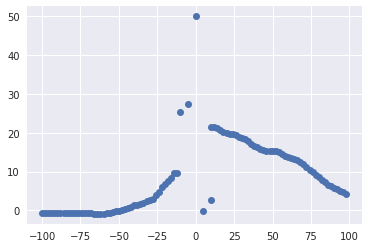

In [18]:
plt.plot(data_gen.iloc[len(data1_gen):]['dt2'],targets[targets1.shape[0]:],'o'), 

In [19]:
ptl_list = [1,2,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [20,40,20]
spk_pairs, targets = arb_w_gen(df=data_gen, ptl_list=ptl_list, targets=targets, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [20]:
# # np.save('/src/Plasticity_Ker/data/spk_pairs.npy', spk_pairs)
# # np.save('/src/Plasticity_Ker/data/targets.npy', targets)
# spk_pairs = np.load('/src/Plasticity_Ker/data/spk_pairs.npy')
# targets = np.load('/src/Plasticity_Ker/data/targets.npy')

In [21]:
targets.shape

(4000, 1)

In [22]:
# Create the network
ground_truth_init = 0
reg_scale=(1, 1)
toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, reg_scale=reg_scale, n_input=spk_pairs.shape[1])

In [23]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_4_real_aug'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [24]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(spk_pairs, targets, test_size=0.1)
X_train, X_vali, y_train, y_vali = train_test_split(X_train_val,  y_train_val, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

[-0.22614121 -0.27994752  0.95375919] 0.0


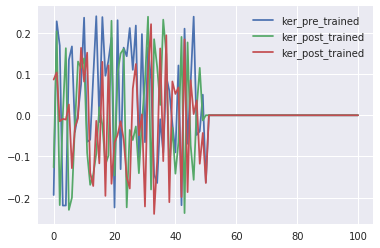

In [25]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.plot(w_post_post,  label='ker_post_trained')
plt.legend()
print(fc_w, bias)

In [53]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3

Global Step 11450 and Step 0046: validation cost=11.71908
Global Step 11500 and Step 0096: validation cost=11.61780
Updated min validation loss!Saving model...
Global Step 11550 and Step 0146: validation cost=11.61889
Global Step 11600 and Step 0196: validation cost=11.66332
Global Step 11650 and Step 0246: validation cost=11.64364
Global Step 11700 and Step 0296: validation cost=11.59557
Updated min validation loss!Saving model...
Global Step 11750 and Step 0346: validation cost=11.80059
Global Step 11800 and Step 0396: validation cost=11.59888
Global Step 11850 and Step 0446: validation cost=11.59522
Updated min validation loss!Saving model...
Global Step 11900 and Step 0496: validation cost=11.63642
Global Step 11950 and Step 0546: validation cost=11.69571
Global Step 12000 and Step 0596: validation cost=11.61742
Global Step 12050 and Step 0646: validation cost=11.60450
Global Step 12100 and Step 0696: validation cost=11.62060
Global Step 12150 and Step 0746: validation cost=11.6326

[array([-1.41763866, -1.26051509,  2.35428977], dtype=float32), 4.6137834]


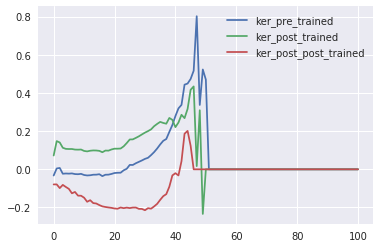

In [54]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(-1*w_pre, label='ker_pre_trained')
plt.plot(-1*w_post, label='ker_post_trained')
plt.plot(w_post_post, label='ker_post_post_trained')
plt.legend()
print([fc_w, bias])

Compare the target and prediction

In [55]:
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w

In [56]:
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs, spk_len=spk_len, kernel=ker_test, net_type='triplet')

In [57]:
# np.save('/src/Plasticity_Ker/data/predictions.npy', predictions)
# predictions = np.load('/src/Plasticity_Ker/data/predictions.npy')

In [58]:
x_fit = np.linspace(np.min(targets)-1, np.max(targets)+1, 100)
targets_stdp = targets[:len(data1_gen)*20]
predictions_stdp = predictions[:len(data1_gen)*20]
targets_triplet = targets[len(data1_gen)*20:len(data1_gen)*20+len(data2_gen)*40]
predictions_triplet = predictions[len(data1_gen)*20:len(data1_gen)*20+len(data2_gen)*40]
targets_quad = targets[len(data1_gen)*20+len(data2_gen)*40:]
predictions_quad = predictions[len(data1_gen)*20+len(data2_gen)*40:]
R2, corr, y_fit = perform_eval.R2_corr(predictions,targets, x_fit)
R2_stdp, corr_stdp, y_fit_stdp = perform_eval.R2_corr(predictions_stdp,targets_stdp, x_fit)
R2_triplet, corr_triplet, y_fit_triplet = perform_eval.R2_corr(predictions_triplet,targets_triplet, x_fit)
R2_quad, corr_quad, y_fit_quad = perform_eval.R2_corr(predictions_quad ,targets_quad, x_fit)

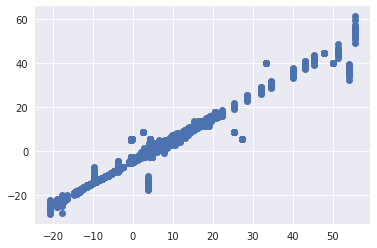

In [59]:
plt.plot(targets,predictions,'o')

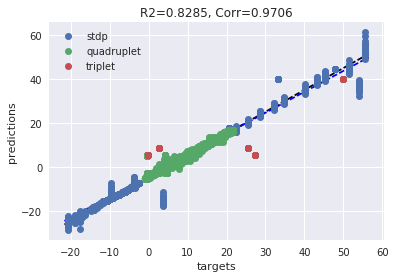

In [60]:
plt.plot(x_fit, y_fit_stdp, 'k--')
#plt.plot(x_fit, y_fit_triplet, 'r--')
plt.plot(x_fit, y_fit_quad, 'b--')

plt.plot(targets_stdp, predictions_stdp, 'o', label='stdp')
plt.plot(targets_quad, predictions_quad, 'o', label='quadruplet')
plt.plot(targets_triplet, predictions_triplet, 'o', label='triplet')

plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))
plt.legend()

In [ ]:
test= spk_pairs[len(data1_gen)*20:, :,:]

In [ ]:
test.shape[0]

In [ ]:
dt2=[]
for i in range(test.shape[0]):
    test_pre = np.where(test[i][:,0]==1)[0]
    test_post = np.where(test[i][:, 1]==1)[0]
    if test_pre[0] < test_post[0]:   # Pre-post-post-pre
        idx = np.arange(0,len(test_post),2)
        test_post_1 = test_post[idx]
        test_post_2 = test_post[idx+1]
        dt2.append(np.mean(test_post_1-test_post_2))
    else:   # Post-pre-pre-post
        idx = np.arange(0,len(test_pre),2)
        test_pre_1 = test_pre[idx]
        test_pre_2 = test_pre[idx+1]
        dt2.append(np.mean(test_pre_2-test_pre_1))

In [ ]:
plt.plot(dt2, targets_quad, 'o')
plt.plot(dt2, predictions_quad, 'o')

Generate test restuls

In [ ]:
ptl_list = [1]
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=X_test, df=data1_gen, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[20])

In [ ]:
targets = y_test

In [ ]:
# Calculate R square
R2 = 1 - np.sum(np.square(predictions - targets))/np.sum(np.square(targets - np.mean(targets)))
# Calculate correlation coefficient
corr = np.sum(np.dot((predictions - np.mean(predictions)).T, targets - np.mean(targets)))/np.std(predictions)/np.std(targets)/len(targets)
b1 = np.sum(np.dot((predictions - np.mean(predictions)).T, targets - np.mean(targets)))/np.sum(np.square(targets - np.mean(targets)))
b2 = np.mean(predictions) - np.mean(targets)*b1
x_fit = np.linspace(np.min(targets)-1, np.max(targets)+1, 100)
y_fit = x_fit * b1 + b2
plt.plot(x_fit, y_fit, 'k--')
plt.plot(targets, predictions, 'ro')
plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))